In [ ]:
!pip install transformers datasets evaluate accelerate bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 38.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os, re
import torch.nn.functional as F
import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
train_path = "/kaggle/input/dataset-finetune/dataset_split_wikidepia/data_latih.csv"
valid_path = "/kaggle/input/dataset-finetune/dataset_split_wikidepia/data_validasi.csv"
uji_path   = "/kaggle/input/dataset-finetune/dataset_split_wikidepia/data_uji.csv"

df_train = pd.read_csv(train_path)[['content', 'summary']]
df_valid = pd.read_csv(valid_path)[['content', 'summary']]
df_uji   = pd.read_csv(uji_path)[['content', 'summary']]

In [ ]:
model_name = "Wikidepia/IndoT5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
prefix = "ringkasan: "

def tokenize_function(batch):
    inputs = tokenizer(prefix + batch['content'], truncation=True, padding="max_length", max_length=512)
    targets = tokenizer(batch['summary'], truncation=True, padding="max_length", max_length=75)
    inputs['labels'] = targets['input_ids']
    return inputs

train_dataset = Dataset.from_pandas(df_train).map(tokenize_function)
val_dataset   = Dataset.from_pandas(df_valid).map(tokenize_function)
uji_dataset   = Dataset.from_pandas(df_uji).map(tokenize_function)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
uji_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)
uji_loader   = DataLoader(uji_dataset, batch_size=4)

Map:   0%|          | 0/12021 [00:00<?, ? examples/s]

Map:   0%|          | 0/1503 [00:00<?, ? examples/s]

Map:   0%|          | 0/1503 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
model.gradient_checkpointing_enable()

checkpoint_dir = "/kaggle/working/checkpoint3-20epoch"
os.makedirs(checkpoint_dir, exist_ok=True)

# Ganti path sesuai nama folder dataset output checkpoint sebelumnya
resume_ckpt = "/kaggle/input/checkpoint3-15epoch/last_model.pt"

def load_checkpoint(path, model, optimizer):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    start_epoch = ckpt["epoch"]
    train_losses = ckpt.get("train_losses", [])
    val_losses   = ckpt.get("val_losses", [])
    print(f"🔁 [Resumed] from epoch {start_epoch}")
    return start_epoch, train_losses, val_losses

learning_rate = 1e-5
weight_decay = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

start_epoch, train_losses, val_losses = load_checkpoint(resume_ckpt, model, optimizer)
best_val_loss = min(val_losses) if val_losses else float("inf")

🔁 [Resumed] from epoch 15


In [ ]:
epochs = start_epoch + 5  # total lanjut hingga 20 dari 15
grad_accum_steps = 4

for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / grad_accum_steps
        loss.backward()
        train_loss += loss.item()

        if (step + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"📊 Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Simpan best checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses
        }, os.path.join(checkpoint_dir, "best_model.pt"))
        print(f"✅ [Best Checkpoint Updated] Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")

    # Simpan last model checkpoint
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses
    }, os.path.join(checkpoint_dir, "last_model.pt"))

Epoch 16 [Val]: 100%|██████████| 376/376 [01:34<00:00,  3.97it/s]


📊 Epoch 16 | Train Loss: 0.1393 | Val Loss: 0.5127
✅ [Best Checkpoint Updated] Epoch 16 | Val Loss: 0.5127


Epoch 17 [Val]: 100%|██████████| 376/376 [01:35<00:00,  3.95it/s]


📊 Epoch 17 | Train Loss: 0.1348 | Val Loss: 0.5019
✅ [Best Checkpoint Updated] Epoch 17 | Val Loss: 0.5019


Epoch 18 [Val]: 100%|██████████| 376/376 [01:34<00:00,  3.97it/s]


📊 Epoch 18 | Train Loss: 0.1317 | Val Loss: 0.4979
✅ [Best Checkpoint Updated] Epoch 18 | Val Loss: 0.4979


Epoch 19 [Val]: 100%|██████████| 376/376 [01:35<00:00,  3.94it/s]


📊 Epoch 19 | Train Loss: 0.1297 | Val Loss: 0.4908
✅ [Best Checkpoint Updated] Epoch 19 | Val Loss: 0.4908


Epoch 20 [Val]: 100%|██████████| 376/376 [01:35<00:00,  3.95it/s]


📊 Epoch 20 | Train Loss: 0.1269 | Val Loss: 0.4867
✅ [Best Checkpoint Updated] Epoch 20 | Val Loss: 0.4867


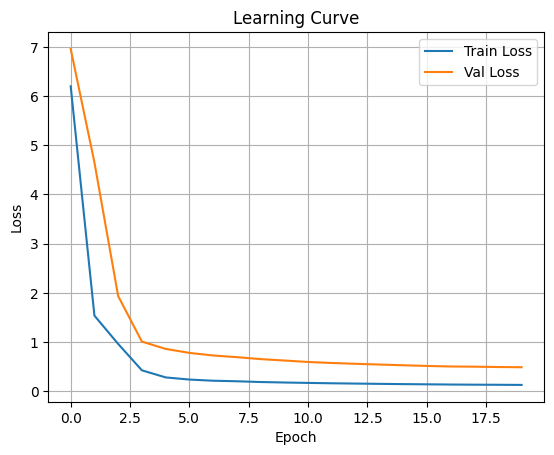

In [ ]:
# Visualisasi Learning Curve
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ==== LOAD BEST MODEL BEFORE EVALUATION ====
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

print("📌 Evaluating using the BEST model.")

📌 Evaluating using the BEST model.


In [ ]:
# Generate ringkasan dari 5 data uji
model.eval()
for i in range(15):
    content = df_uji.iloc[i]['content']
    reference = df_uji.iloc[i]['summary']

    inputs = tokenizer(content, return_tensors="pt", max_length=512, truncation=True).to(device)
    output = model.generate(inputs['input_ids'], max_length=75, num_beams=4, early_stopping=True)
    predicted = tokenizer.decode(output[0], skip_special_tokens=True)

    print(f"\n📄 Artikel Uji {i+1}")
    print("Content:", content[:300].strip().replace('\n', ' '), "...")
    print("Reference:", reference.strip())
    print("Predicted:", predicted.strip())


📄 Artikel Uji 1
Content: Seorang pengunjung Kebun Raya Bogor mengeluhkan adanya dugaan pungutan liar (pungli) yang dilakukan oleh pengelola terhadapnya dan puluhan rekannya saat gathering menggelar sejumlah perlombaan di lapangan Cappelen, Kebun Raya Bogor. Dugaan pungutan liar (pungli) tersebut diunggah dalam bentuk video ...
Reference: Sekuriti Kebun Raya Bogor menanyakan kepada panitia lantaran mereka tak memberi tahu ke pengelola ihwal acara bersama rombongan.
Predicted: Pengunjung Kebun Raya Bogor mengeluhkan adanya dugaan pungutan liar( pungli) yang dilakukan oleh pihak internal maupun eksternal.

📄 Artikel Uji 2
Content: Lembaga Bantuan Hukum (LBH) Padang mengirim somasi kepada Polda Sumatera Barat pada Rabu, 5 Februari 2025 karena tidak memenuhi putusan Komisi Informasi (KI) Nomor 22/VIII/KISB-PS-M-A/2024. Putusan itu memerintahkan Polda Sumbar dalam 14 hari kerja agar memberikan bekas-berkas kasus kematian Afif Ma ...
Reference: Komisi Informasi mengabulkan permohonan LBH Pad

In [ ]:
import evaluate

meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")
rouge = evaluate.load("rouge")

predictions = []
references = []

model.eval()
for i in range(len(df_uji)):
    content = df_uji.iloc[i]['content']
    reference = df_uji.iloc[i]['summary']

    inputs = tokenizer(content, return_tensors="pt", max_length=512, truncation=True).to(model.device)
    output = model.generate(
        inputs["input_ids"],
        max_length=75,
        num_beams=4,
        early_stopping=True
    )
    pred = tokenizer.decode(output[0], skip_special_tokens=True)

    predictions.append(pred)
    references.append(reference)

meteor_result = meteor.compute(predictions=predictions, references=references)
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="id")
rouge_result = rouge.compute(predictions=predictions, references=references)

print("\n📊 Evaluation on Test Set")
print("-" * 40)

print("🔹 METEOR")
print(f"METEOR     : {meteor_result['meteor']:.4f}")
print("-" * 40)

print("🔹 BERTScore")
print(f"Precision  : {np.mean(bertscore_result['precision']):.4f}")
print(f"Recall     : {np.mean(bertscore_result['recall']):.4f}")
print(f"F1         : {np.mean(bertscore_result['f1']):.4f}")
print("-" * 40)

print("🔹 ROUGE")
print(f"ROUGE-1    : {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2    : {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L    : {rouge_result['rougeL']:.4f}")
print(f"ROUGE-Lsum : {rouge_result['rougeLsum']:.4f}")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


📊 Evaluation on Test Set
----------------------------------------
🔹 METEOR
METEOR     : 0.3334
----------------------------------------
🔹 BERTScore
Precision  : 0.7660
Recall     : 0.7717
F1         : 0.7684
----------------------------------------
🔹 ROUGE
ROUGE-1    : 0.3482
ROUGE-2    : 0.2041
ROUGE-L    : 0.3176
ROUGE-Lsum : 0.3179


In [ ]:
import os, shutil

export_path = "/kaggle/working/finetune_best_model_20epoch"
model.save_pretrained(export_path)
tokenizer.save_pretrained(export_path)
print(f"🎉 Best model exported to {export_path}")

# ZIP folder export_path
shutil.make_archive(export_path, 'zip', export_path)

# ZIP checkpoint_dir
shutil.make_archive(checkpoint_dir, 'zip', checkpoint_dir)

print("✅ Zipping done!")
print("Export ZIP  :", export_path + ".zip")
print("Checkpoint ZIP:", checkpoint_dir + ".zip")

🎉 Best model exported to /kaggle/working/finetune_best_model_20epoch
✅ Zipping done!
Export ZIP  : /kaggle/working/finetune_best_model_20epoch.zip
Checkpoint ZIP: /kaggle/working/checkpoint3-20epoch.zip
